<img src="https://github.com/denisabrantes/pdk-use-cases/blob/main/images/hpe_logo.png?raw=true" alt="HPE Logo" width="250" style="align:left;margin-left:0;"/>

<h1>Object Detection Prediction from KServe InferenceService</h1>

<b>Date: 08/30/23</b><br/>
<b>Version: 0.1</b><br/>
<b>Authors: HPE AI At Scale SE Team</b>

<img src="https://github.com/denisabrantes/pdk-use-cases/blob/main/images/platform_step0.png?raw=true" alt="Enterprise Machine Learning platform architecture" width="850">

<h3>Import modules and define functions</h3>
The cells below imports all modules and libraries required to run the demo.

In [1]:
#!pip install -q ipywidgets
#!pip install scikit-image

In [2]:
import sys
import glob
import base64
import json
import requests
import matplotlib.pyplot as plt

from skimage import io
from PIL import Image, ImageDraw
from ipywidgets import interact, interactive
import ipywidgets as widgets
import io

from tqdm import tqdm
from multiprocessing import Pool

<h2>Part 1: Use this code to load images from a folder and generate predictions</h2>

<h4>Step 1: Setting up connection details to KServe</h4>

In [3]:
endpoint_name = 'detection-deploy'
model_name ='object-detection'
ingress_host = "192.168.1.2"
ingress_port = "80"
service_hostname = "detection-deploy.models.example.com"

<h4>Step 2: Request prediction from KServe InferenceService</h4>

In [4]:
def plot_pred(im,pred_d,thres=0.15):
    draw = ImageDraw.Draw(im)
    try:
        for pred in pred_d['predictions'][0]:
            assert len(list(pred.keys())) == 2
            cl_name = list(pred.keys())[0]
            bboxes = pred[cl_name]
            if pred['score'] > thres:
                draw.rectangle([bboxes[0],bboxes[1],bboxes[2],bboxes[3]],outline=(255,0,0),fill=None,width=1)
                draw.text([bboxes[0],bboxes[1]-10],"{} :{:.2f}".format(cl_name,pred['score']),fill=(250,0,0))
        plt.figure(figsize=(8,8))
    except Exception as e:
        print(e)
        pass
    plt.imshow(im)
    plt.show()
    return im

In [5]:
def predict(args):
    image= Image.open(args[0])
    with io.BytesIO() as buffer:
        image.save(buffer, format='JPEG')
        image_bytes = buffer.getvalue()
    image_64_encode = base64.b64encode(image_bytes)
    bytes_array = image_64_encode.decode("utf-8")
    
    # Format the request in json
    request = {
      "instances":[
        {
          "data": bytes_array
        }
      ]
    }
    ingress_host = args[1]
    ingress_port = args[2]
    model_name = args[3]
    service_hostname = args[4]

    url = str("http://") + str(ingress_host) + ":" + str(ingress_port) + "/v1/models/" + str(model_name) + ":predict"
    headers = {'Host': service_hostname}
    payload = json.dumps(request)

    response = requests.post(url, data=payload, headers=headers)
    return response.json()

In [6]:
def visualize(idx,thres=0.15):
    print(idx,thres)
    output = resps[idx]
    im = Image.open(imgs[idx])
    plot_pred(im,output,thres)

In [7]:
def run_apply_async_multiprocessing(func, argument_list, num_processes):
    pool = Pool(processes=num_processes)

    jobs = [pool.apply_async(func=func, args=(*argument,)) if isinstance(argument, tuple) else pool.apply_async(func=func, args=(argument,)) for argument in argument_list]
    pool.close()
    result_list_tqdm = []
    for job in tqdm(jobs):
        result_list_tqdm.append(job.get())

    return result_list_tqdm

In [8]:
images = r"./images/*.jpg"

In [9]:
imgs = [img for img in glob.glob(images, recursive=True)]

In [10]:
resps = run_apply_async_multiprocessing(predict,
                                        [[imgs[i],
                                        ingress_host,
                                        ingress_port,
                                        model_name,
                                        service_hostname] for i in range(len(imgs))],num_processes=4)

100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


0 0.0


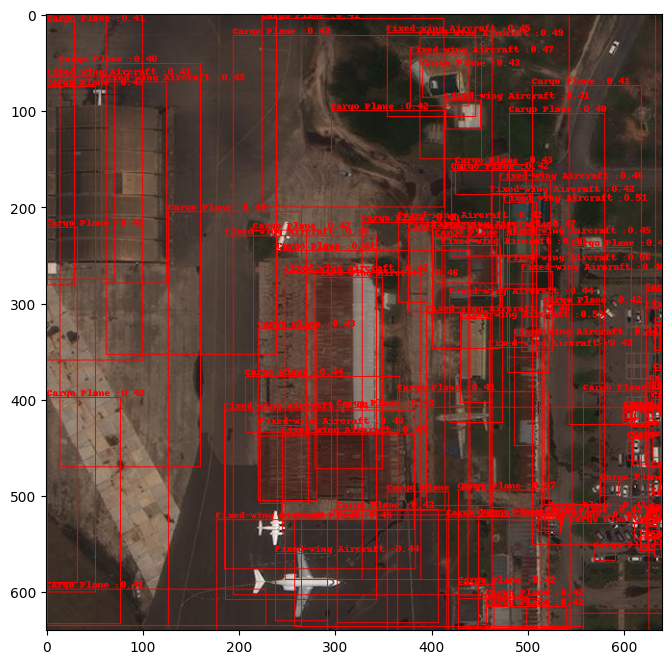

interactive(children=(IntSlider(value=0, description='idx', max=1), FloatSlider(value=0.0, description='thres'…

In [11]:
interact(visualize, 
         idx=widgets.IntSlider(min=0, max=len(resps), step=1, value=0),
         thres = widgets.FloatSlider(min=0, max=1.0, step=0.1, value=0.00));

<h2>Part 2: Use this code to load the sample .json files and generate predictions</h2>

In [12]:
with open("object_detection.json", "r") as objfile:
    imgfile = json.loads(objfile.read())

In [14]:
jsonimg = imgfile["instances"][0]["data"]

In [15]:
# Format the request in json
request = {
  "instances":[
    {
      "data": jsonimg
    }
  ]
}

url = str("http://") + str(ingress_host) + ":" + str(ingress_port) + "/v1/models/" + str(model_name) + ":predict"
headers = {'Host': service_hostname}
payload = json.dumps(request)

response = requests.post(url, data=payload, headers=headers)

In [17]:
print(response.json())

{'predictions': [[{'Fixed-wing Aircraft': [479.9593811035156, 257.3749694824219, 509.8717956542969, 356.4295959472656], 'score': 0.5578479766845703}, {'Fixed-wing Aircraft': [430.53961181640625, 316.1061706542969, 463.02593994140625, 403.14697265625], 'score': 0.5272318124771118}, {'Fixed-wing Aircraft': [475.32720947265625, 195.12539672851562, 509.9393005371094, 280.4083557128906], 'score': 0.5131145715713501}, {'Fixed-wing Aircraft': [388.51690673828125, 24.13599967956543, 452.3835144042969, 150.89292907714844], 'score': 0.4941963255405426}, {'Fixed-wing Aircraft': [0.462026983499527, 0.0, 100.98030853271484, 359.9579162597656], 'score': 0.4917139708995819}, {'Fixed-wing Aircraft': [186.36337280273438, 230.2782745361328, 343.5081481933594, 608.880615234375], 'score': 0.4909256100654602}, {'Cargo Plane': [609.0335083007812, 440.1556701660156, 622.8472900390625, 468.0729675292969], 'score': 0.4855831265449524}, {'Cargo Plane': [428.2005920410156, 494.1185607910156, 514.95263671875, 607